# **Bayesian Network Analysis for Cardiovascular Risk Prediction**
#### Project 1: Advanced Machine Learning
**Group Members:**
- **João Ascenso, Nº 56939**
- **Alexandre Baptista, Nº 64506**

### **Introduction**

With the objective of examining the relationships between cardiovascular risk factors and additional factors that may contribute to the development of cardiovascular diseases, we constructed a Bayesian network. This network was learned from a dataset of annual health assessments, where each cardiovascular risk factor, health condition, and related attribute is represented as a node. Through this approach, the network provides insights into the probabilistic dependencies among these factors, enabling a better understanding of their interactions and potential impacts on cardiovascular health.

### **Dependencies**

The implementation relies on the following key libraries:

- **pandas**: For data preprocessing and manipulation.
- **matplotlib**: For creating visualizations.
- **pgmpy**: For constructing, estimating, and analyzing the Bayesian network.
- **imbalanced-learn (imblearn)**: For applying SMOTEN and random undersampling to address class imbalance.
- **scikit-learn**: For performance evaluation metrics.

### **1. Exploratory Data Analysis**

The given dataset is already discretized, containing non-null and categorized values as described in the project statement. It comprises 3,845 rows and 13 categorical features: `Age`, `Anxiety`, `Depression`, `Diabetes`, `Education Level`, `Hypercholesterolemia`, `Hypertension`, `Physical Activity`, `Sex`, `Sleep Duration`, `Smoker Profile`, `Socioeconomic Status`, and `Body Mass Index`.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter

In [3]:
df = pd.read_csv("cardiovascular_train.csv")
df.head()

,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,54-64,No,Overweight,No,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3
1,24-34,No,Obese,No,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3
2,24-34,No,Overweight,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1
3,34-44,No,Overweight,No,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3
4,44-54,No,Overweight,No,Yes,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845 entries, 0 to 3844
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   3845 non-null   object
 1   Anxiety               3845 non-null   object
 2   BodyMassIndex         3845 non-null   object
 3   Depression            3845 non-null   object
 4   Diabetes              3845 non-null   object
 5   EducationLevel        3845 non-null   int64 
 6   Hypercholesterolemia  3845 non-null   object
 7   Hypertension          3845 non-null   object
 8   PhysicalActivity      3845 non-null   object
 9   Sex                   3845 non-null   object
 10  SleepDuration         3845 non-null   object
 11  SmokerProfile         3845 non-null   object
 12  SocioeconomicStatus   3845 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 390.6+ KB


To explore potential patterns or imbalances in the data, we visualized the class distributions for all features using bar plots. The following observations were made:

1. **Imbalanced Variables**:  
   - **Diabetes, Anxiety, and Depression**: The "No" category strongly dominates over "Yes," making these features highly imbalanced.

2. **Balanced Variables**:  
   - **Socioeconomic Status**: The three levels are fairly balanced, with approximately equal counts for each category.

3. **Detailed Feature Analysis**:
   - **Age**: The dataset spans six discrete age ranges, with the majority of individuals falling within the 34–44 and 44–54 categories.
   - **Body Mass Index (BMI)**: Most individuals are categorized as Overweight or Normal, while Underweight is the least common category.
   - **Education Level**: Level 2 is the most represented, while Level 1 is the least represented.
   - **Physical Activity**: Insufficiently Active individuals make up a significantly larger proportion compared to those classified as Regularly Active.
   - **Sleep Duration**: The majority of individuals report sleeping 6–9 hours, with fewer individuals sleeping <6 hours or >9 hours.
   - **Smoker Profile**: Non-Smokers constitute the largest group, followed by Smokers and Ex-Smokers.
   - **Sex**: The dataset has roughly twice as many Males as Females.
   - **Hypertension and Hypercholesterolemia**: Both conditions show an imbalance, with the "No" category being more prevalent than "Yes."

This analysis highlights important patterns in the dataset, such as class imbalances and variable distributions, which will guide the subsequent modeling and evaluation steps.

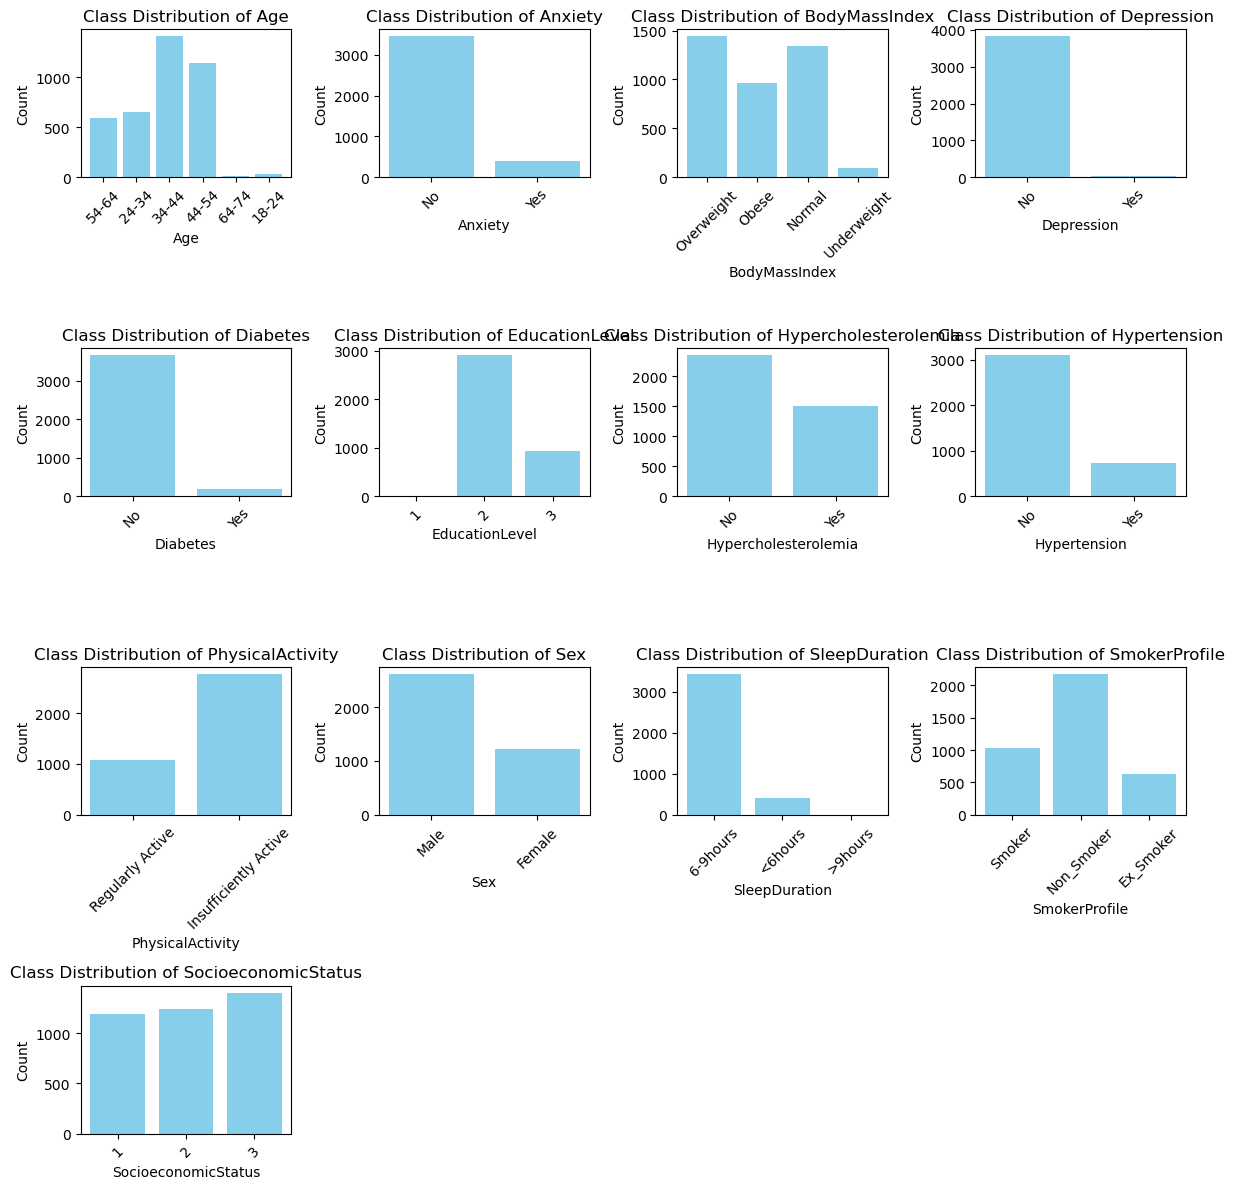

In [5]:
features = list(df.columns)
num_features = len(features)
cols = 4
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
axes = axes.flatten()

for i, feature in enumerate(features):
    counter = Counter(df[feature])

    labels = counter.keys()
    counts = counter.values()
    
    axes[i].bar(labels, counts, color='skyblue')
    axes[i].set_title(f'Class Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **2. Learn a Bayesian Network from the Data**

In this step, we applied structure and parameter learning techniques to construct a Bayesian network from the provided dataset.


In [6]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
from IPython.display import Image, display
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD

#### **Structure Learning**

For structure learning, we used the **Hill Climbing Search** algorithm with the **BDeu score** as the scoring function. This choice was informed by the following reasons:

- **Why Hill Climbing Search?**
  - Hill Climbing is a heuristic search algorithm that begins with an initial DAG and iteratively optimizes a scoring function by making single-edge manipulations.
  - Compared to **Exhaustive Search**, which evaluates all possible structures, Hill Climbing is computationally efficient and can handle datasets with more variables. Exhaustive Search, while guaranteed to find the optimal structure, becomes impractical for larger networks due to its exponential complexity.

- **Why the BDeu Score?**
  - Compared to **BIC** and **AIC** scores, which penalize model complexity relative to dataset size, the BDeu score incorporates prior knowledge through an equivalent sample size parameter (default is 5). This ensures that the learned structure strikes a balance between being overly simplistic or excessively complex, particularly for smaller datasets where BIC and AIC may over-penalize and miss important dependencies.
  - The **K2 Prior** was not chosen because it applies a fixed pseudo-count to all states, which lacks the flexibility of the BDeu score that dynamically adjusts the contribution of prior knowledge based on the equivalent sample size.

To ensure the network aligned with domain knowledge, we imposed the following **fixed edges** based on logical causal relationships:
- `Age → BodyMassIndex`
- `PhysicalActivity → Hypertension`
- `PhysicalActivity → Hypercholesterolemia`
- `PhysicalActivity → SmokerProfile`

These fixed edges were added to guide the learning algorithm without overly constraining the model, allowing it to discover other relationships autonomously.
Adding these fixed edges also showed improvement in the Bayesian score.

In [7]:
df = pd.read_csv("cardiovascular_train.csv")

bdeu = BDeuScore(df)
es = HillClimbSearch(data=df)
best_model = es.estimate(
    scoring_method=bdeu,
    fixed_edges=[
        ('Age', 'BodyMassIndex'),
        ('PhysicalActivity', 'Hypertension'),
        ('PhysicalActivity', 'Hypercholesterolemia'),
        ('PhysicalActivity', 'SmokerProfile')
    ]
)
print('Nodes:', best_model.nodes())
print('Edges:', best_model.edges())
print('Bayesian score:', bdeu.score(best_model))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Nodes: ['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes', 'EducationLevel', 'Hypercholesterolemia', 'Hypertension', 'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile', 'SocioeconomicStatus']
Edges: [('Age', 'BodyMassIndex'), ('Age', 'SmokerProfile'), ('Age', 'PhysicalActivity'), ('Age', 'SocioeconomicStatus'), ('Age', 'SleepDuration'), ('Age', 'Hypercholesterolemia'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SocioeconomicStatus'), ('Depression', 'EducationLevel'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'Hypercholesterolemia'), ('EducationLevel', 'SocioeconomicStatus'), ('Hypercholesterolemia', 'SleepDuration'), ('Hypercholesterolemia', 'Hypertension'), ('Hypercholesterolemia', 'SmokerProfile'), ('Hypertension', 'Anxiety'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'SmokerProfile'), ('PhysicalActivity', 'Hypercholesterolemia'), ('PhysicalActivity', 'EducationLevel'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('Sex', 'Hyper

#### **Visualizing the Network**

The resulting Bayesian network was visualized to examine the dependencies between variables and validate the plausibility of the learned structure. This visualization provided valuable insights into the relationships discovered by the model, highlighting the following notable observations:

- **Fixed Edges**:
  - **Age → BodyMassIndex**: Reflects the impact of aging on BMI.
  - **PhysicalActivity → Hypertension** and **PhysicalActivity → Hypercholesterolemia**: Show physical activity's role in managing these conditions.
  - **PhysicalActivity → SmokerProfile**: Highlights the link between smoking and activity levels.
- **Non-Modifiable Influences**:
  - Age significantly impacts BodyMassIndex, SleepDuration, and SocioeconomicStatus.
  - Sex influences PhysicalActivity, reflecting gender-based behavioral trends.
- **Modifiable Risk Factors**:
  - PhysicalActivity directly influences Hypertension and Hypercholesterolemia.
  - SmokerProfile links to Hypercholesterolemia, emphasizing smoking’s impact.
- **Medical Conditions**:
  - Strong interactions between Hypercholesterolemia, Hypertension, and Diabetes reflect shared cardiovascular risk pathways.

By combining fixed edges with data-driven learning, the network provides a logical and interpretable structure for analyzing cardiovascular risk factors.

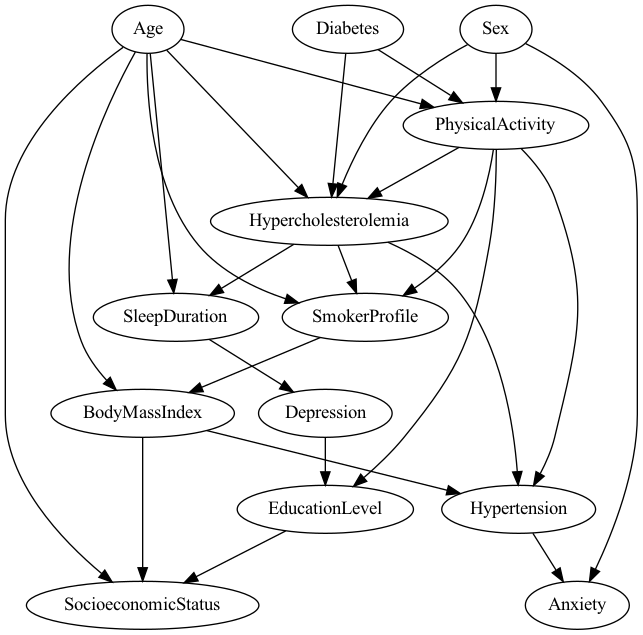

In [8]:
m = best_model.to_graphviz()
img = m.draw(format='png',prog="dot")
display(Image(img))

#### **Parameter Learning**

Once the network structure was identified, we used the **Bayesian Estimator** with a **BDeu prior** for parameter learning. This decision was guided by the following considerations:

- **Why Bayesian Estimator?**
  - It incorporates prior distributions, which act as pseudo-counts, mitigating the risk of overfitting that arises with **Maximum Likelihood Estimation (MLE)**. MLE would result in zero probabilities for states not observed in the data, which is undesirable.
  - Unlike **Expectation-Maximization (EM)**, which is suitable for datasets with latent variables, the Bayesian Estimator is more appropriate for our dataset since all variables are fully observer, directly computing the conditional probability distributions using the observed data.

- **Why the BDeu Prior?**
  - The BDeu prior introduces equivalent pseudo-counts, which ensures no state has zero probability. This is particularly useful for rare observations in the data, preventing overfitting.
  - The BDeu prior dynamically adjusts pseudo-counts, making it more flexible than the fixed counts used in the **K2 Prior**. Additionally, it simplifies parameter learning by removing the need to manually define pseudo-counts, as required by the **Dirichlet prior**.

By employing these methods, we achieved a balance between computational efficiency, robustness, and adaptability to imbalanced or sparse data, ensuring a reliable and well-structured Bayesian network capable of capturing meaningful dependencies.

In [9]:
bm = BayesianNetwork()
bm.add_nodes_from(best_model.nodes())
bm.add_edges_from(best_model.edges())

In [10]:
bm.fit(df, estimator=BayesianEstimator, prior_type='BDeu')

### **Visualizing the CPDs**

To better understand the learned parameters, we analyzed the Conditional Probability Distributions (CPDs). Below is a summary of the CPDs for the variables of interest: `Age`, `Hypertension`, `SmokerProfile`, `SleepDuration`, and `Diabetes`.

- **CPD for Age**:
  - The distribution reflects a dataset skewed toward middle-aged individuals:
    - **Dominant Groups**: Ages **34-44** and **44-54** are most prevalent.
    - **Underrepresented Groups**: Ages **18-24** and **64-74** are minimally represented, which may limit insights for these demographics.

- **CPD for Diabetes**:
  - A significant imbalance is evident, with:
    - **Non-Diabetics** making up 95.36% of the dataset.
    - **Diabetics** representing only 4.64%.
  - This imbalance poses challenges for analyzing diabetic-related patterns due to the limited representation of this subgroup.

- **CPD for Hypertension**:
  - Hypertension likelihood is influenced by BodyMassIndex, Hypercholesterolemia, and PhysicalActivity:
    - **BodyMassIndex**: Higher hypertension probabilities are associated with the Obese, Overweight and Underweight categories.
    - **Hypercholesterolemia**: Individuals with hypercholesterolemia have a higher likelihood of hypertension.
    - **PhysicalActivity**: Regularly active individuals show lower probabilities of hypertension across all conditions.
  - This CPD emphasizes the interplay between lifestyle, health conditions, and physiological factors.

- **CPD for SleepDuration**:
  - The analysis highlights key trends:
    - **Normal Sleep (6-9 hours)**: Most common across all age and Hypercholesterolemia categories.
    - **Short (<6 hours)**: Slightly more frequent in older individuals with hypercholesterolemia.
    - **Long (>9 hours)**: Rare across all groups.
    - **Health Implications**: A connection between hypercholesterolemia and shorter sleep durations is observed, especially in older demographics.

- **CPD for SmokerProfile**:
  - Smoking behavior is segmented by age, hypercholesterolemia, and physical activity:
    - **Non-Smokers**: Predominant among younger individuals and regularly active groups.
    - **Ex-Smokers**: More common in older groups.
    - **Smokers**: More prevalent among older, insufficiently active individuals with hypercholesterolemia.
  - This CPD underscores the relationships between smoking, lifestyle habits, and health conditions, offering valuable insights for health interventions.

In [11]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [12]:
variables_of_interest = ["Age", "Hypertension", "SmokerProfile", "SleepDuration", "Diabetes"]

for cpd in bm.get_cpds():
    if cpd.variable in variables_of_interest:
        print(f"CPD for {cpd.variable}:")
        print_full(cpd)

CPD for Age:
+------------+------------+
| Age(18-24) | 0.00748918 |
+------------+------------+
| Age(24-34) | 0.170346   |
+------------+------------+
| Age(34-44) | 0.36671    |
+------------+------------+
| Age(44-54) | 0.298398   |
+------------+------------+
| Age(54-64) | 0.154502   |
+------------+------------+
| Age(64-74) | 0.00255411 |
+------------+------------+
CPD for Diabetes:
+---------------+-----------+
| Diabetes(No)  | 0.953636  |
+---------------+-----------+
| Diabetes(Yes) | 0.0463636 |
+---------------+-----------+
CPD for Hypertension:
+----------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+--------------

### **3. Network and problem analysis**

To analyze the relationships between variables in the Bayesian network, we employed Variable Elimination, an exact inference method. This method is ideal for our analysis as it efficiently calculates conditional probabilities by avoiding the computation of the full joint distribution, which would be computationally expensive and impractical for large models. Unlike approximate inference methods, such as Gibbs sampling, Variable Elimination provides precise results without relying on sampling or approximations.

Below, we detail our analysis of key relationships within the network:

In [13]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(bm)

**1. Effect of Age on Sleep Duration**

The analysis of sleep duration by age highlights distinct trends:

- **6-9 Hours Sleep**: This is the most common category across all age groups, with younger groups (18-24 and 24-34) showing higher probabilities compared to older groups (54-64 and 64-74), where it declines.

- **<6 Hours Sleep**: Short sleep durations increase with age, being rare in younger groups but more prevalent in older ones, reflecting age-related challenges like sleep disorders.

- **>9 Hours Sleep**: Long sleep durations are uncommon across all ages, with a slight increase in older groups but remaining minimal overall.

Key Insights:
1. **Dominance of Normal Sleep**: The 6-9 hours category remains prevalent across all ages.
2. **Age-Related Sleep Decline**: Older groups show a shift toward shorter sleep durations, indicating potential health or lifestyle issues.
3. **Rare Long Sleep**: >9 hours sleep remains consistently rare, unaffected by age trends.

These findings suggest a need to address sleep quality in older populations to mitigate risks associated with insufficient sleep.

In [14]:
unique_age_values = sorted(df['Age'].unique())
for age_value in unique_age_values:
    result = infer.query(['SleepDuration'], evidence={'Age': age_value})
    print("P(SleepDuration | Age = " + age_value + ")")
    print(result)

P(SleepDuration | Age = 18-24)
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9804 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0098 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0098 |
+-------------------------+----------------------+
P(SleepDuration | Age = 24-34)
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9405 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0575 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0020 |
+-------------------------+----------------------+
P(SleepDuration | Ag

**2. How Smoker Profile Affects the Three Medical Conditions**

The smoker profile influences the probabilities of **Diabetes**, **Hypertension**, and **Hypercholesterolemia**:

- **Diabetes**: 
  - **Smokers** have a slightly higher probability of diabetes compared to **non-smokers** and **ex-smokers**.
  - Quitting smoking reduces the risk, but ex-smokers still face slightly elevated probabilities.

- **Hypertension**:
  - Risk increases from **non-smokers** to **ex-smokers**, with **smokers** showing the highest probability, indicating a strong correlation between smoking and high blood pressure.

- **Hypercholesterolemia**:
  - **Smokers** and **ex-smokers** have higher probabilities compared to **non-smokers**, emphasizing the negative impact of smoking on cholesterol levels.

**Key Insights**:
- Smoking significantly increases the risk of these conditions.
- Quitting smoking helps reduce risks but does not fully eliminate them.
- Promoting non-smoking behavior and cessation programs is critical for improving public health.

In [15]:
medical_conditions = ['Diabetes', 'Hypertension', 'Hypercholesterolemia']
unique_smoker_profile_values = sorted(df['SmokerProfile'].unique())

for smoker_profile_value in unique_smoker_profile_values:
    print("Results for SmokerProfile = " + smoker_profile_value + ":")
    for medical_condition in medical_conditions:
        result = infer.query([medical_condition], evidence={'SmokerProfile': smoker_profile_value})
        print("P(" + medical_condition + " | SmokerProfile = " + smoker_profile_value + ")")
        print(result)

Results for SmokerProfile = Ex_Smoker:
P(Diabetes | SmokerProfile = Ex_Smoker)
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9558 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0442 |
+---------------+-----------------+
P(Hypertension | SmokerProfile = Ex_Smoker)
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.8154 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.1846 |
+-------------------+---------------------+
P(Hypercholesterolemia | SmokerProfile = Ex_Smoker)
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.5564 |
+------------------------

**3. How Body Mass Index Affects the Three Medical Conditions**

The impact of Body Mass Index (BMI) on **Diabetes**, **Hypertension**, and **Hypercholesterolemia** is summarized below:

- **Diabetes**:
  - **Underweight** individuals show a slightly higher likelihood of diabetes compared to other BMI categories (**Normal**, **Overweight**, **Obese**), suggesting potential metabolic risks at low BMI levels.

- **Hypertension**:
  - The probability of hypertension increases with BMI, peaking in the **Obese** category, followed by **Overweight**. **Underweight** individuals have the lowest risk.

- **Hypercholesterolemia**:
  - Hypercholesterolemia probabilities are slightly higher in **Underweight** individuals compared to other BMI categories, indicating potential cholesterol imbalances at low BMI levels.

**Key Insight**:
  - BMI strongly predicts hypertension risk, with higher BMI categories linked to greater likelihoods. For diabetes and hypercholesterolemia, extreme BMI values (both high and low) show a notable influence.

Maintaining a healthy BMI is essential for reducing risks of hypertension, diabetes, and hypercholesterolemia.

In [16]:
medical_conditions = ['Diabetes', 'Hypertension', 'Hypercholesterolemia']
unique_bmi_values = sorted(df['BodyMassIndex'].unique())

for bmi_value in unique_bmi_values:
    print("Results for BodyMassIndex = " + bmi_value + ":")
    for medical_condition in medical_conditions:
        result = infer.query([medical_condition], evidence={'BodyMassIndex': bmi_value})
        print("P(" + medical_condition + " | BodyMassIndex = " + bmi_value + ")")
        print(result)

Results for BodyMassIndex = Normal:
P(Diabetes | BodyMassIndex = Normal)
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9525 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0475 |
+---------------+-----------------+
P(Hypertension | BodyMassIndex = Normal)
+-------------------+---------------------+
| Hypertension      |   phi(Hypertension) |
+===================+=====================+
| Hypertension(No)  |              0.8009 |
+-------------------+---------------------+
| Hypertension(Yes) |              0.1991 |
+-------------------+---------------------+
P(Hypercholesterolemia | BodyMassIndex = Normal)
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.5749 |
+---------------------------+--------

### **4. Classification of the Three Medical Conditions**

Using the test dataset and the trained Bayesian model, we evaluated the model's performance in predicting the three medical conditions: `Diabetes`, `Hypertension`, and `Hypercholesterolemia`. For this assessment, we generated classification reports, which include precision, recall, and F1-score metrics.

**Why Use Precision, Recall, and F1-Score?**

Metrics like accuracy and AUC provide an overall measure of model performance but may not fully capture the nuances of imbalanced datasets. In this case, the dataset shows significant class imbalance (e.g., a small proportion of **Yes** cases for **Diabetes** and **Hypertension**). 

- **Precision** measures how many of the predicted positives are actual positives, which is crucial for avoiding false positives in medical diagnoses.
- **Recall** measures how many of the actual positives are correctly identified, emphasizing the importance of minimizing false negatives.
- **F1-Score** provides a harmonic mean of precision and recall, offering a balanced evaluation metric when both false positives and false negatives are critical.

In [17]:
from sklearn.metrics import  classification_report

In [18]:
test = pd.read_csv("cardiovascular_test.csv")

In [19]:
X_test_diabetes = test.drop(columns=["Diabetes"])
y_test_diabetes = test["Diabetes"]

X_test_hypertension = test.drop(columns=["Hypertension"])
y_test_hypertension = test["Hypertension"]

X_test_hypercholesterolemia = test.drop(columns=["Hypercholesterolemia"])
y_test_hypercholesterolemia = test["Hypercholesterolemia"]

In [20]:
pred_diabetes = bm.predict(X_test_diabetes)
pred_hypertension = bm.predict(X_test_hypertension)
pred_hypercholesterolemia = bm.predict(X_test_hypercholesterolemia)

  0%|          | 0/808 [00:00<?, ?it/s]

  0%|          | 0/741 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

**Key Observations from the Reports**

1. **Diabetes Classification**:
   - The model achieved high precision and recall for the **No** class but struggled with the **Yes** class due to the small number of positive cases. The overall accuracy was 96%, but the F1-score for the **Yes** class was only 0.03, reflecting poor performance in identifying diabetic cases.

2. **Hypertension Classification**:
   - The **No** class was classified with high precision (83%) and recall (99%). However, the **Yes** class had a much lower recall (7%) and precision (61%), indicating difficulty in identifying hypertensive individuals. The F1-score for the **Yes** class was 0.13, highlighting room for improvement.

3. **Hypercholesterolemia Classification**:
   - The performance for this condition was more balanced, with moderate precision (71% for **No** and 66% for **Yes**) and recall (87% for **No** and 43% for **Yes**). The F1-scores (0.78 for **No** and 0.52 for **Yes**) suggest better but still limited ability to identify positive cases.

The classification reports underscore the challenges of imbalanced datasets in medical diagnosis, where the **Yes** class often represents the minority. While the model performs well for the majority classes, it underperforms for the minority classes, indicating the need for strategies like data balancing or more sophisticated modeling techniques to improve detection of the positive cases.

In [22]:
print("Diabetes Classification Report:")
print(classification_report(y_test_diabetes, pred_diabetes, target_names=['No', 'Yes']))
print("Hypertension Classification Report:")
print(classification_report(y_test_hypertension, pred_hypertension, target_names=['No', 'Yes']))
print("Hypercholesterolemia Classification Report:")
print(classification_report(y_test_hypercholesterolemia, pred_hypercholesterolemia, target_names=['No', 'Yes']))

Diabetes Classification Report:
              precision    recall  f1-score   support

          No       0.96      1.00      0.98      1224
         Yes       1.00      0.02      0.03        58

    accuracy                           0.96      1282
   macro avg       0.98      0.51      0.51      1282
weighted avg       0.96      0.96      0.93      1282

Hypertension Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.99      0.90      1052
         Yes       0.61      0.07      0.13       230

    accuracy                           0.83      1282
   macro avg       0.72      0.53      0.52      1282
weighted avg       0.79      0.83      0.76      1282

Hypercholesterolemia Classification Report:
              precision    recall  f1-score   support

          No       0.71      0.87      0.78       795
         Yes       0.66      0.43      0.52       487

    accuracy                           0.70      1282
   macro avg    

### **5. Improving Classification Results**

To address the imbalance in the **Diabetes** dataset, we applied **SMOTEN** along with **Random Undersampling**. These methods work in tandem to balance the data by oversampling the minority class ("Yes") and reducing the majority class ("No"). This approach prevents the model from overfitting to the majority class and improves its ability to predict minority outcomes.

**Why SMOTEN and Undersampling?**
- **SMOTEN**: Selected from the SMOTE variations because it is designed for **categorical data**, which aligns with the features in our dataset. Unlike traditional SMOTE, which works with numerical data, SMOTEN creates synthetic samples by considering the categorical nature of the variables, maintaining data integrity.
- **Random Undersampling**: Reduces the majority class to ensure the dataset remains balanced without inflating its size, which could otherwise lead to computational inefficiency.

**Steps Taken**
1. **Original Diabetes Class Distribution**: The dataset was highly imbalanced with 3669 samples for "No" vs. 176 for "Yes".
2. **Balancing the Dataset**: SMOTEN and random undersampling resulted in a balanced distribution of 1834 samples per class.
3. **Retraining the Bayesian Network**: A new Bayesian network was learned using **HillClimbSearch** and **BDeu scoring** on the balanced dataset, ensuring the model incorporated the newly synthesized data.
4. **Retesting**: The model was retested on the same test set used in step 4 to evaluate the impact of balancing.

In [23]:
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import RandomUnderSampler

In [24]:
df = pd.read_csv("cardiovascular_train.csv")
df.head()

,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,54-64,No,Overweight,No,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3
1,24-34,No,Obese,No,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3
2,24-34,No,Overweight,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1
3,34-44,No,Overweight,No,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3
4,44-54,No,Overweight,No,Yes,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3


In [25]:
X = df.drop(columns=["Diabetes"])
y = df["Diabetes"]

Original Diabetes class distribution: Counter({'No': 3669, 'Yes': 176})


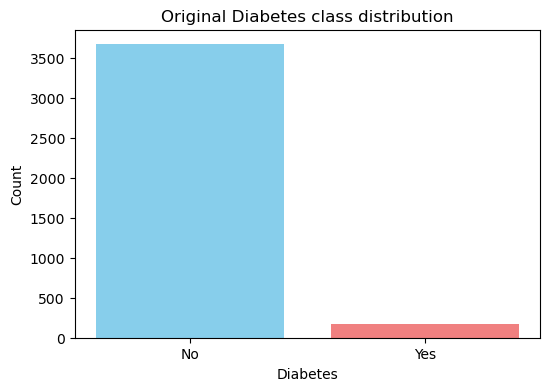

In [26]:
counter = Counter(y)
print("Original Diabetes class distribution:", counter)

labels = counter.keys()
counts = counter.values()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Original Diabetes class distribution')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

In [27]:
sm = SMOTEN(sampling_strategy=0.5)
X_res, y_res = sm.fit_resample(X, y)
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_res, y_res)

New class distribution after SMOTEN: Counter({'No': 1834, 'Yes': 1834})


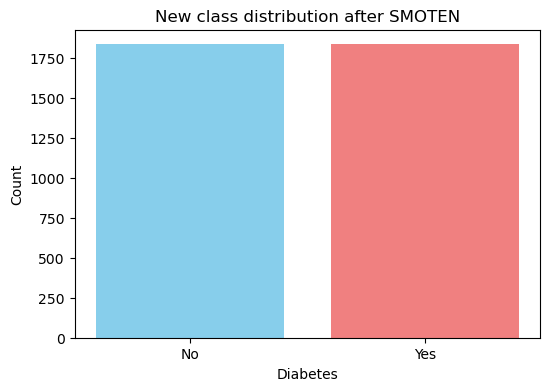

In [28]:
counter_res = Counter(y_res)
print("New class distribution after SMOTEN:", counter_res)

labels_res = counter_res.keys()
counts_res = counter_res.values()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels_res, counts_res, color=['skyblue', 'lightcoral'])
plt.title('New class distribution after SMOTEN')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

In [29]:
balanced_df = pd.concat([X_res, y_res.rename("Diabetes")], axis=1)

In [ ]:
# structure estimation  
bdeu = BDeuScore(balanced_df)
es = HillClimbSearch(data=balanced_df)
best_model = es.estimate(
    scoring_method=bdeu,
    fixed_edges=[
        ('Age', 'BodyMassIndex'),
        ('PhysicalActivity', 'Hypertension'),
        ('PhysicalActivity', 'Hypercholesterolemia'),
        ('PhysicalActivity', 'SmokerProfile')
    ]
)
print('Edges:', best_model.edges())
print('Bayesian score:', bdeu.score(best_model))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges: [('Age', 'BodyMassIndex'), ('Age', 'PhysicalActivity'), ('Age', 'SmokerProfile'), ('Age', 'Sex'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'Hypercholesterolemia'), ('BodyMassIndex', 'SmokerProfile'), ('Depression', 'Anxiety'), ('EducationLevel', 'Diabetes'), ('EducationLevel', 'Age'), ('EducationLevel', 'Depression'), ('Hypercholesterolemia', 'Hypertension'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'SmokerProfile'), ('PhysicalActivity', 'Hypercholesterolemia'), ('Sex', 'PhysicalActivity'), ('Sex', 'Hypercholesterolemia'), ('Sex', 'Hypertension'), ('Sex', 'SmokerProfile'), ('Sex', 'Anxiety'), ('SleepDuration', 'Depression'), ('SmokerProfile', 'Hypercholesterolemia'), ('SmokerProfile', 'SleepDuration'), ('SocioeconomicStatus', 'Sex'), ('SocioeconomicStatus', 'Age'), ('SocioeconomicStatus', 'Diabetes'), ('SocioeconomicStatus', 'EducationLevel'), ('SocioeconomicStatus', 'BodyMassIndex'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'BodyMassIndex'), 

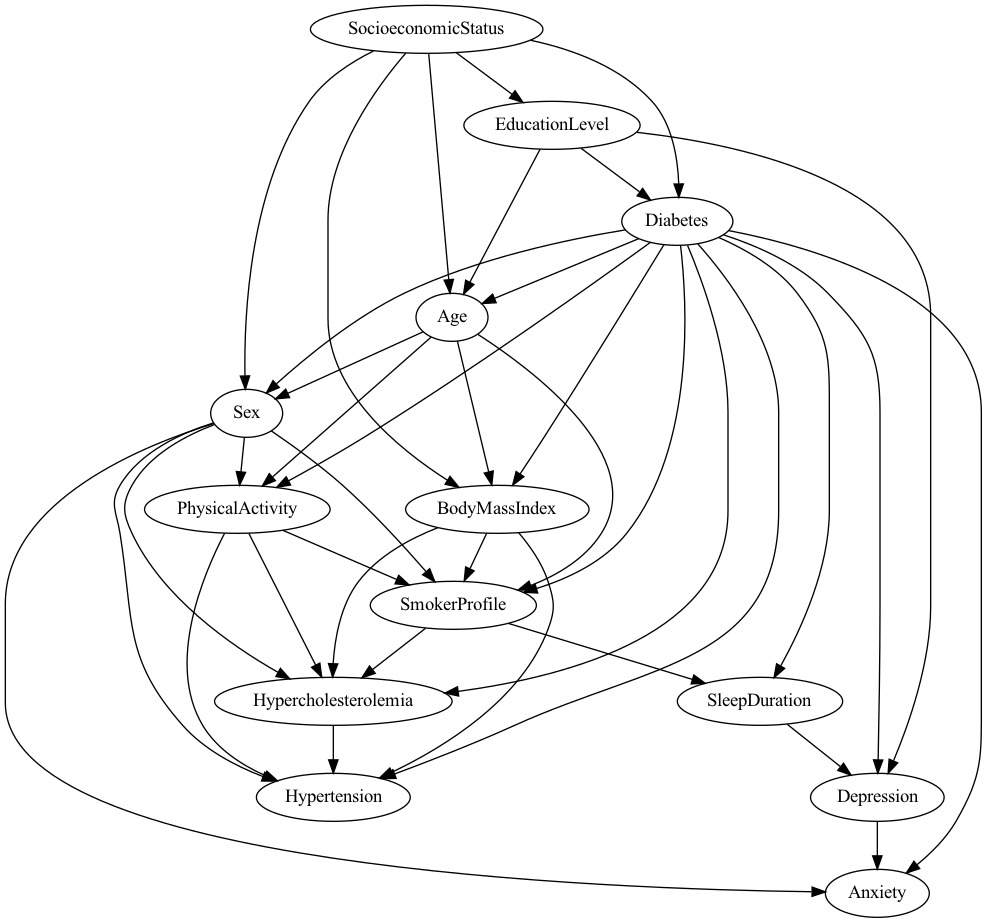

In [31]:
m = best_model.to_graphviz()
img = m.draw(format='png',prog="dot")
display(Image(img))

In [32]:
bm = BayesianNetwork()
bm.add_nodes_from(best_model.nodes())
bm.add_edges_from(best_model.edges())

In [33]:
# parameter estimation
bm.fit(df, estimator=BayesianEstimator, prior_type='BDeu')

In [ ]:
# for cpd in bm.get_cpds():
#     print_full(cpd)

In [34]:
test = pd.read_csv("cardiovascular_test.csv")

In [35]:
X_test_diabetes = test.drop(columns=["Diabetes"])
y_test_diabetes = test["Diabetes"]

X_test_hypertension = test.drop(columns=["Hypertension"])
y_test_hypertension = test["Hypertension"]

X_test_hypercholesterolemia = test.drop(columns=["Hypercholesterolemia"])
y_test_hypercholesterolemia = test["Hypercholesterolemia"]

In [36]:
pred_diabetes = bm.predict(X_test_diabetes)
pred_hypertension = bm.predict(X_test_hypertension)
pred_hypercholesterolemia = bm.predict(X_test_hypercholesterolemia)

  0%|          | 0/808 [00:00<?, ?it/s]

  0%|          | 0/741 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

In [37]:
print("Diabetes Classification Report:")
print(classification_report(y_test_diabetes, pred_diabetes, target_names=['No', 'Yes']))
print("Hypertension Classification Report:")
print(classification_report(y_test_hypertension, pred_hypertension, target_names=['No', 'Yes']))
print("Hypercholesterolemia Classification Report:")
print(classification_report(y_test_hypercholesterolemia, pred_hypercholesterolemia, target_names=['No', 'Yes']))

Diabetes Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.99      0.98      1224
         Yes       0.41      0.12      0.19        58

    accuracy                           0.95      1282
   macro avg       0.69      0.56      0.58      1282
weighted avg       0.93      0.95      0.94      1282

Hypertension Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.99      0.90      1052
         Yes       0.61      0.09      0.15       230

    accuracy                           0.83      1282
   macro avg       0.72      0.54      0.53      1282
weighted avg       0.79      0.83      0.77      1282

Hypercholesterolemia Classification Report:
              precision    recall  f1-score   support

          No       0.69      0.88      0.77       795
         Yes       0.64      0.34      0.45       487

    accuracy                           0.68      1282
   macro avg    

#### **Results of Applying SMOTEN and Random Undersampling**
- **Diabetes**:
  - **Recall** for the minority class improved significantly from 0.02 to 0.12, with the **f1-score** increasing from 0.03 to 0.19.
  - Accuracy remained about the same from 95% to 96%, but minority class metrics showed better balance.

- **Hypertension**:
  - Minority class **recall** improved slightly from 0.07 to 0.09, with a minor increase in the **f1-score** from 0.13 to 0.15.
  - Overall accuracy remained at 83%, with stable majority class performance.

- **Hypercholesterolemia**:
  - Minority class **recall** decreased from 0.34 to 0.43, and the **f1-score** decreased from 0.45 to 0.52.
  - Accuracy improved slightly from 70% to 68%.

The use of **SMOTEN** for categorical data and **Random Undersampling** effectively addressed class imbalance, significantly improving **Diabetes** minority class recall and f1-score. These changes ensured:
- Better identification of minority class cases while maintaining majority class performance.
- Improved balance in predictions, with minimal impact on overall accuracy.

While **Diabetes** saw the most substantial gains, moderate improvements in **Hypertension** and **Hypercholesterolemia** suggest the need for further refinements in balancing techniques for these conditions.

### **Conclusion**

This project effectively applied **Bayesian networks** to model and analyze the probabilistic dependencies among cardiovascular risk factors, yielding meaningful insights and robust predictions. Key achievements include:

1. **Exploratory Data Analysis**:
   - Identified significant class imbalances, particularly in **Diabetes**.
   - Provided insights into feature distributions and their relationships with cardiovascular risks.

2. **Bayesian Network Construction**:
   - The structure was learned using **HillClimbSearch** with **BDeu scoring**, combining data-driven insights with domain knowledge to ensure interpretability.
   - Parameter learning via the **Bayesian Estimator** provided robust probability estimates while minimizing overfitting.

3. **Classification Improvements**:
   - Addressed **imbalance in Diabetes data** using **SMOTEN** (for categorical oversampling) and **Random Undersampling**, improving recall and F1-score for the minority class.
   - Predictions for **Hypertension** and **Hypercholesterolemia** remained about the same.

4. **Key Findings**:
   - Strong predictors like **Smoking Behavior** and **BMI** were identified, offering actionable insights for health interventions.
   - Detailed probabilistic analysis revealed the interplay between factors such as age, sleep duration, and cardiovascular conditions.

This project demonstrates the effectiveness of **Bayesian networks** for healthcare analytics, creating a robust and interpretable model for cardiovascular risk prediction.